## Estimating House Prices in Tehran


The main aim of this excercise is to 

**Importing the required Libraries:** 

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler , OneHotEncoder , OrdinalEncoder , LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

**Reading the .csv File:**

In [71]:
# Read the CSV file
dataset = pd.read_csv("House_data.csv")
# Take a look at the dataset
dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


**Make a Histogram to Figure out Which Areas are Outlier Data:**

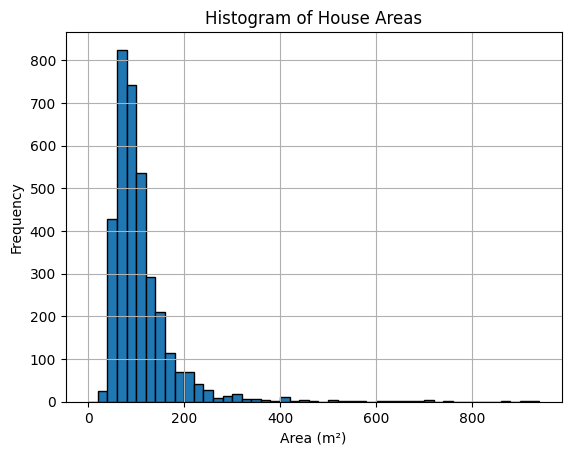

In [72]:
# Select the 'Area' column
cdf = dataset[['Area']]

# Convert the 'Area' column to numeric values to handle any non-numeric entries
cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')

# Define the bin width
bin_width = 20

# Calculate the number of bins
bins = range(0, int(cdf['Area'].max()) + bin_width, bin_width)

# Create the histogram
plt.figure()
plt.hist(cdf['Area'], bins=bins, edgecolor='black')
plt.title('Histogram of House Areas')
plt.xlabel('Area (m²)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


According to the histogram, we can neglect the houses with area larger than 300 m2!

**Visualization of Data:**

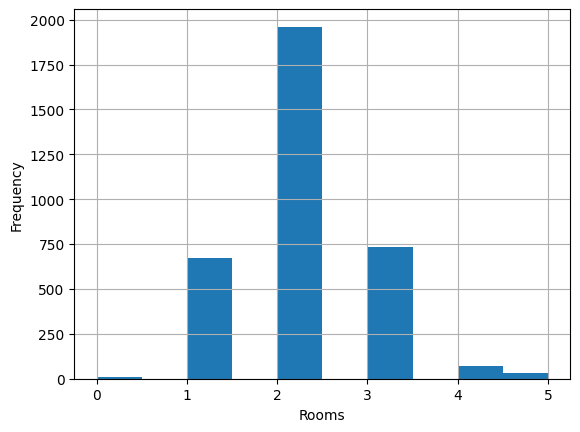

In [73]:
cdf = dataset[['Room']]
plt.figure()
plt.hist(cdf['Room'])
plt.xlabel('Rooms')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Cleaning dataset**

In [74]:
# Remove rows with an area over 300 m²
dataset = dataset[pd.to_numeric(dataset['Area'], errors='coerce') <= 300]

# Remove rows where the address is empty or missing
dataset = dataset[dataset['Address'].notna() & dataset['Address'].str.strip().astype(bool)]

# Select the 'Area' column
cdf = dataset[['Area']]

# Convert the 'Area' column to numeric values to handle any non-numeric entries
cdf['Area'] = pd.to_numeric(cdf['Area'], errors='coerce')

# Drop any NaN values that resulted from conversion
cdf = cdf.dropna()


#### **Split Dataset into Train and Test**

In [76]:
Y= dataset["Price"]
X= dataset.drop(["Price"] , axis=1)
x_train , x_test , y_train ,y_test=train_test_split(X , Y , test_size=0.2  , random_state=42)
num_col = ["Area"]
cat_col_1hot=list(x_train[[ "Parking" , "Warehouse" , "Elevator" , "Address"]])
cat_col_ord=["Room"]
full_pipeline=ColumnTransformer([
    ("norm" , MinMaxScaler() ,num_col ) , 
    ("1hot" , OneHotEncoder() ,cat_col_1hot ),
    ("ordinal" , OrdinalEncoder() , cat_col_ord)
])
combined_data = pd.concat([x_train, x_test], axis=0)
combined_data_preprocessed = full_pipeline.fit_transform(combined_data)
x_train_preprocessed = combined_data_preprocessed[:len(x_train)]
x_train_preprocessed_dense=x_train_preprocessed.toarray()
x_test_preprocessed = combined_data_preprocessed[len(x_train):]
x_test_preprocessed_dense=x_test_preprocessed.toarray()



#### **Select a Suitable Model**

In [77]:
las=Lasso(alpha=0.1)
y_pred_test = las.fit(x_train_preprocessed_dense, y_train)
y_pred_train = cross_val_predict(las, x_train_preprocessed_dense, y_train, cv=5) 
model_mse = mean_squared_error(y_train, y_pred_train)
model_rmse = np.sqrt(model_mse)
R2 = r2_score(y_train, y_pred_train)
print(f"Model: {las.__class__.__name__}")
print(f"RMSE: {model_rmse}")
print(f"R2 Score: {R2}")

Model: Lasso
RMSE: 2891080059.9479384
R2 Score: 0.774111233170987


#### **Visualization**

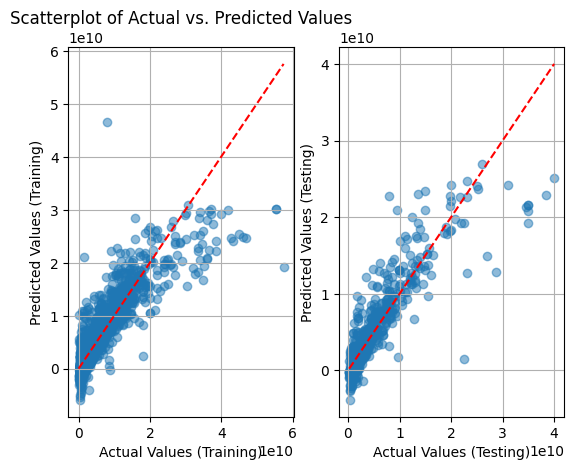

In [83]:
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5 )
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red')
plt.xlabel("Actual Values (Training)")
plt.ylabel("Predicted Values (Training)")
plt.title("Scatterplot of Actual vs. Predicted Values")
plt.grid(True)
plt.subplot(1, 2, 2)
y_pred_test=las.predict(x_test_preprocessed_dense)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("Actual Values (Testing)")
plt.ylabel("Predicted Values (Testing)")
plt.grid(True)

#### **Model Evaluation**

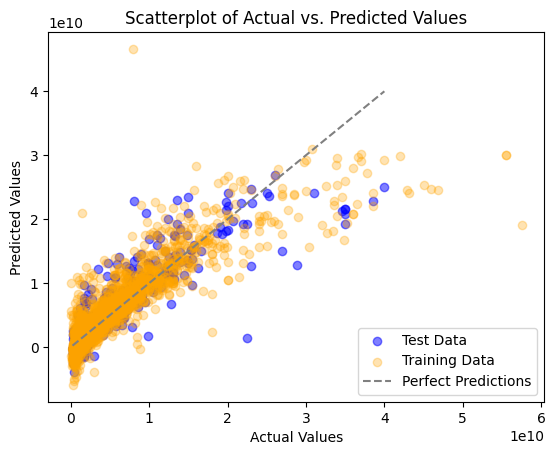

In [80]:
plt.figure()
plt.scatter(y_test, y_pred_test, label='Test Data', color='blue', alpha=0.5)
plt.scatter(y_train, y_pred_train, label='Training Data', color='orange', alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', label='Perfect Predictions')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatterplot of Actual vs. Predicted Values')
plt.legend()
plt.show()